In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%201/Exercises/TFLite_Week1_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%201/Exercises/TFLite_Week1_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

In [104]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.3.0
• GPU Device Found.


In [2]:
len(tf.config.list_physical_devices('GPU')) > 0 

True

# Download Fashion MNIST Dataset

We will use TensorFlow Datasets to load the Fashion MNIST dataset. 

In [105]:
# splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))
splits = ("train[:80%]", "train[:10%]", "train[:10%]")  # my try 1
# splits = ("train[:80]", "train[:10]", "train[:10]")

# SPLIT_WEIGHTS = (8, 1, 1)
# splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)


splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [106]:
splits

(<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>)

In [96]:
# 查看 fashion mnist 信息
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [97]:
print(num_examples)
print(num_classes)

60000
10


In [98]:
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

The class names are not included with the dataset, so we will specify them here.

In [99]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

0 T恤/上衣
1	裤子
2	套头衫
3	连衣裙
4	外套
5	凉鞋
6	衬衫
7	运动鞋
8	包
9	短靴

In [56]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [57]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

In [66]:
train_examples

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

(28, 28, 1)


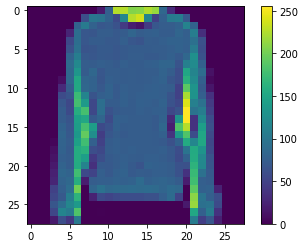

TensorShape([28, 28, 1])

In [82]:
# 查看dataset样本数据
for img, label in train_examples.take(1):
  print(img.shape) # img
  # print(label.numpy()) 
  # print(img.numpy())
  img_example = np.squeeze(img.numpy())
  img_lable = label.numpy()
  plt.figure()
  plt.imshow(np.squeeze(img.numpy()))
  plt.colorbar()
  plt.grid(False)
  plt.show()
img.shape

In [83]:
img_example

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  18,  77, 227, 227,
        208, 210, 225, 216,  85,  32,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  61, 100,  97,  80,  57, 117,
        227, 238, 115,  49,  78, 106, 108,  71,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  81, 105,  80,  69,  72,  64,  44,
         21,  13,  44,  69,  75,  75,  80, 114,  80,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  26,  92,  69,  68,  75,  75,  71,  74,
         83,  75,  77,  78,  74,  74,  83,  77, 108,  34,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  55,  92,  69,  74,  74,  71,  71,  77,
         69,  66,  75,  74,  77,  80,  80,  78,  94,  63,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  63,  95,  66,  68,  72,  72,  69,  72,
         74,  74,  74,  75,  75,  77,  80,  77, 106,  61,   0,   0,   0,
          0,   0],
       [  

In [84]:
img_lable

2

# Preprocessing data

## Preprocess

In [107]:
# EXERCISE: Write a function to normalize the images.

def format_example(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32)
    # image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE)) 
        
    # Normalize the image in the range [0, 1]
    image = image / 255.0
    
    # label = tf.keras.utils.to_categorical(label,num_classes)
    return image, label

In [109]:
# Specify the batch size
BATCH_SIZE = 256

In [88]:
# img_example_cvt, img_label_cvt = format(img_example, img_lable)

TypeError: ignored

## Create Datasets From Images and Labels

In [108]:

# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.batch(1).map(format_example)

In [102]:
# Create Datasets
# train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
# validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
# test_batches = test_examples.batch(1).map(format_example)
# # train_batches = train_examples.shuffle(num_examples//4).map(format_example).batch(BATCH_SIZE).prefetch(1)
# validation_batches = validation_examples.map(format_example).batch(BATCH_SIZE).prefetch(1)
# test_batches = test_examples.map(format_example).batch(1)

TypeError: ignored

dataset.cache() 功能！！ ToDo

In [110]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([256, 28, 28, 1])

In [111]:
label_batch.shape

TensorShape([256])

In [112]:
for test_image_batch, test_label_batch in validation_batches.take(1):
  pass
test_image_batch.shape

TensorShape([256, 28, 28, 1])

In [113]:
test_label_batch.shape

TensorShape([256])

# Building the Model

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [44]:
# EXERCISE: Build and compile the model shown in the previous cell.

model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, activation='relu',input_shape=(28, 28, 1)),
      
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),
      
    # Attach a final softmax classification head
    tf.keras.layers.Dense(num_classes, activation='softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                247872    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
________________________________________________

## Train

In [46]:
validation_batches

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [47]:
validation_examples

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [114]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10


ValueError: ignored

# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE

In [ ]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = # YOUR CODE HERE

# Set the optimzations
converter.optimizations = # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = # YOUR CODE HERE

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

# Test the Model with TFLite Interpreter 

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 12 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download the TFLite Model and Assets

If you are running this notebook in a Colab, you can run the cell below to download the tflite model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [ ]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [ ]:
try:
    files.download('fmnist_test_images.zip')
except:
    pass